### Yolov8 vs Yolov5

#### Lets compare two Yolo series models and find out which would be better for deployment, assuming both have similar evaluation metrics.

In [152]:
# Import libraries
from typing import Tuple, Dict
from ultralytics.utils.plotting import colors
from ultralytics.utils import ops
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2
import random
from time import perf_counter
import numpy as np

In [4]:
# YOLOv5 PyTorch HUB Inference
yolov5_model = torch.hub.load('ultralytics/yolov5', 'yolov5n', force_reload=True, trust_repo=True)  # yolov5-l
im = 'images/highway.jpg'  # file
results = yolov5_model(im, size=640)  # inference
results.print()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/angel/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-1-21 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 472x655 36 cars, 3 trucks
Speed: 9.2ms pre-process, 67.5ms inference, 8.1ms NMS per image at shape (1, 3, 480, 640)


In [5]:
# YOLOv8
# Load a model
yolov8_model = YOLO('yolov8n.pt')  # load a pretrained model

# Use the model
results = yolov8_model(im, imgsz=640)  # inference


image 1/1 /home/angel/computer_vision/production_challenge/images/highway.jpg: 480x640 40 cars, 3 trucks, 51.0ms
Speed: 1.5ms preprocess, 51.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


##### Profiler function leverage with ultralytics api

In [33]:
def profile_yolov8(img, iters=1000, size=640):
    results = {'preprocess': [],
                'inference': [],
                'postprocess': []}
    # warmup
    for i in range(0, 10):
        yolov8_results = yolov8_model(img, imgsz=size, verbose=False) # inference
    # profile preprocess, inference and postprocess
    for i in range(0, iters):
        yolov8_results = yolov8_model(img, imgsz=size, verbose=False) # inference
        s = yolov8_results[0].speed
        results['preprocess'].append(s['preprocess'])
        results['inference'].append(s['inference'])
        results['postprocess'].append(s['postprocess'])
        
    return results

In [210]:
def profile_yolov5(img, iters=1000, size=640):
    results = {'preprocess': [],
                'inference': [],
                'postprocess': []}
    # warmup
    for i in range(0, 10):
        yolov5_results = yolov5_model(im, size=640)  # inference
    # profile preprocess, inference and postprocess
    for i in range(0, iters):
        yolov5_results = yolov5_model(im, size=640)  # inference
        pre, inf, post = yolov5_results.tolist()[0].t
        results['preprocess'].append(pre)
        results['inference'].append(inf)
        results['postprocess'].append(post)
        
    return results

In [ ]:
yolov8_list_res = profile_yolov8(img=im)
yolov5_list_res = profile_yolov5(img=im)

#### Plot Results

In [298]:
def plot_speed_metrics(src_1, src_2, names=['yolov8', 'yolov5'], key='inference', show=True, save=False):
    data_1 = np.array(src_1[key])
    data_2 = np.array(src_2[key])

    data = [data_1, data_2]

    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    bp = ax.boxplot(data, patch_artist = True,
                    notch ='True', vert = 0)

    colors = ['#0000FF', '#00FF00', 
            '#FFFF00', '#FF00FF']

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")

    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                linewidth = 3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                color ='#e7298a',
                alpha = 0.5)
        
    # x-axis labels
    ax.set_yticklabels([names[0], names[1]])

    # Adding title 
    plt.title(key.capitalize())

    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    mu_1 = data_1.mean()
    mu_2 = data_2.mean()
    textstr = '\n'.join((
        r'$\mu :%s=%.2f$ ms' % (names[0], mu_1, ),
        r'$\mu :%s=%.2f$ ms' % (names[1], mu_2, )))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.72, 0.88, textstr, transform=ax.transAxes, fontsize=14, bbox=props)
        
    # show plot
    if show:
        plt.show()
    if save:
        path = os.path.join("images",key+".png")
        fig.savefig(path)
        
    return {names[0]:mu_1, names[1]:mu_2}

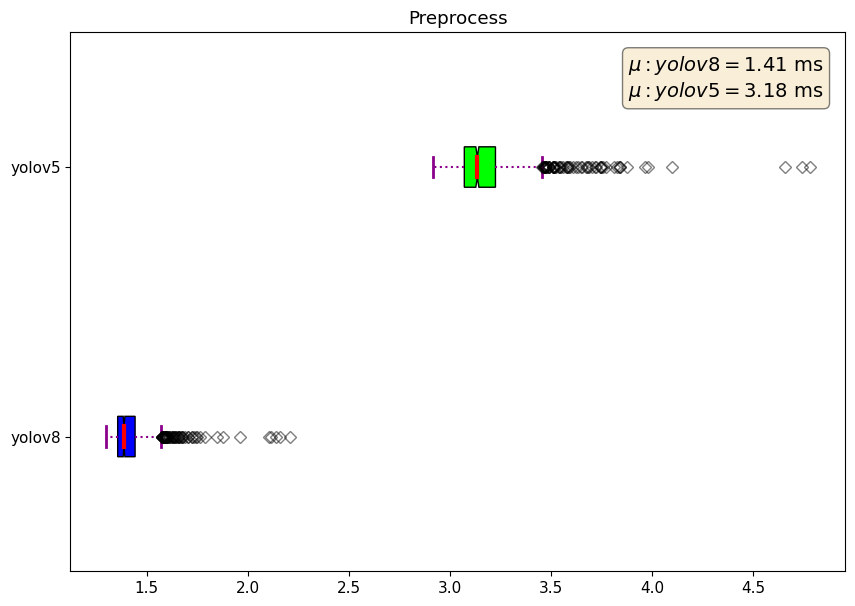

{'yolov8': 1.4149408340454102, 'yolov5': 3.1782989501953125}

In [301]:
# preprocess plot
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='preprocess', show=True, save=True)

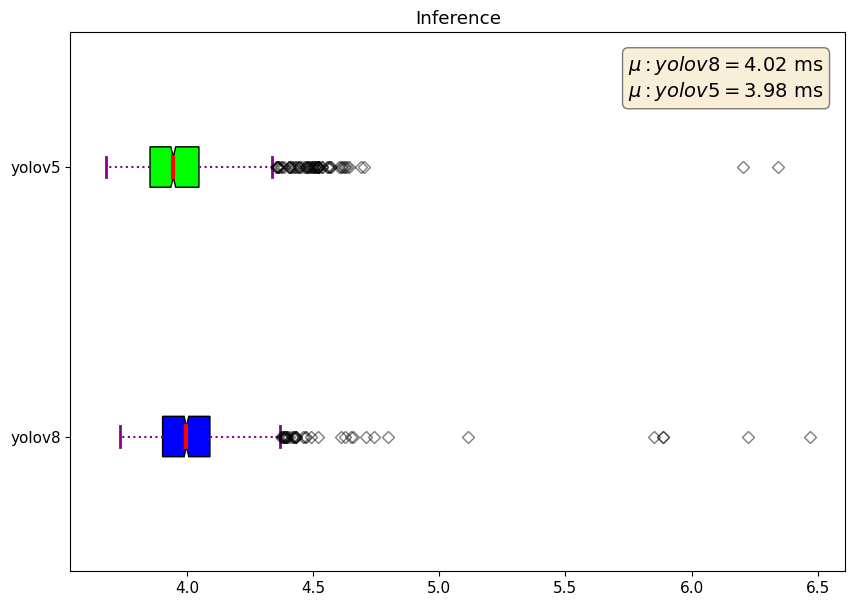

{'yolov8': 4.021538496017456, 'yolov5': 3.978715181350708}

In [300]:
# inference plot
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='inference', show=True, save=True)

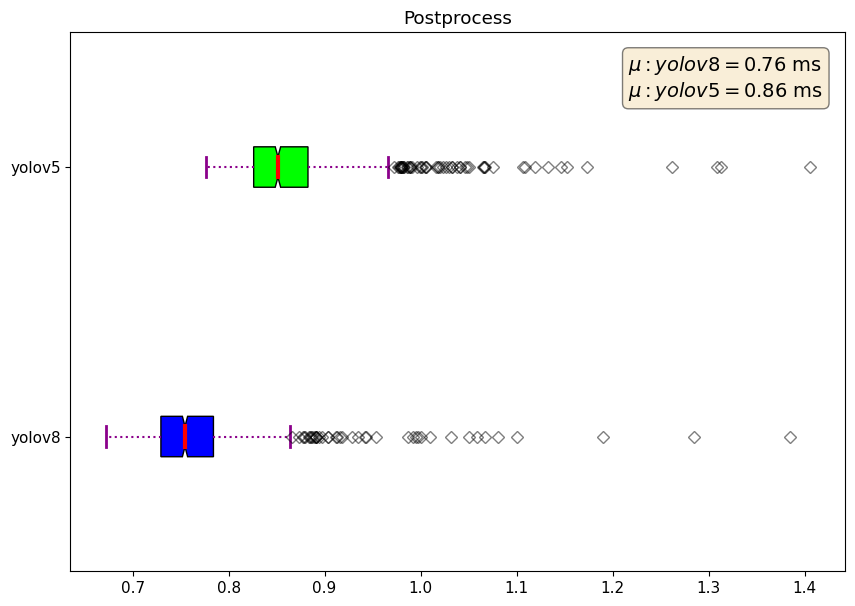

{'yolov8': 0.7629940509796143, 'yolov5': 0.8629152774810791}

In [302]:
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='postprocess', show=True, save=True)

#### Optimization

In [228]:
# Export the model
yolov8_model.export(format='onnx', imgsz=(480,640),half=True, simplify=True, opset=13, device=0)

Ultralytics YOLOv8.1.3 🚀 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 480, 640) BCHW and output shape(s) (1, 84, 6300) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 13...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 0.5s, saved as 'yolov8n.onnx' (6.1 MB)

Export complete (0.6s)
Results saved to /home/angel/computer_vision/production_challenge
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=480,640 half 
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=480,640 data=coco.yaml half WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[480, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.ap

'yolov8n.onnx'

In [124]:
yolov8_model.export(format='onnx', imgsz=(480,640), dynamic=True, simplify=True, opset=11, device=0)

Ultralytics YOLOv8.1.3 🚀 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 480, 640) BCHW and output shape(s) (1, 84, 6300) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 11...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 0.9s, saved as 'yolov8n.onnx' (12.1 MB)

Export complete (0.9s)
Results saved to /home/angel/computer_vision/production_challenge
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=480,640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=480,640 data=coco.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[480, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.app


'yolov8n.onnx'

In [399]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load(r"yolov8n.onnx")
onnx.checker.check_model(onnx_model)

In [408]:
providers = ['CUDAExecutionProvider']
ort_sess = ort.InferenceSession(r'yolov8n.onnx', providers=providers)
ort_sess.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
input = ort_sess.get_inputs()[0].name
output = ort_sess.get_outputs()[0].name
io_binding = ort_sess.io_binding()

In [7]:
from yolo_utils import LetterBox

In [22]:
img = cv2.imread(r"/home/angel/computer_vision/production_challenge/images/highway.jpg")
preprocess = LetterBox(new_shape=(480,640))
prepro_img, _ = preprocess(image = img)
t_img = np.transpose(prepro_img, (2, 0, 1)).astype("float32")/255
t_img = t_img[None,:,:,:]

In [411]:
io_binding.bind_cpu_input(input, t_img)
io_binding.bind_output(output)
ort_sess.run_with_iobinding(io_binding)
Y = io_binding.copy_outputs_to_cpu()[0]

In [82]:
def timer(f,*args):   
    start = perf_counter()
    f.run_with_iobinding(*args)
    return (1000 * (perf_counter() - start))

In [415]:
print(f"Yolov8 ORT: {np.mean([timer(ort_sess,io_binding) for _ in range(10000)])} ms")

Yolov8 ORT: 4.2402817899666845 ms


##### TensorRT

In [168]:
yolov8_model.export(format='onnx', imgsz=(480,640), simplify=True, opset=13, device=0, dynamic=True, batch=8)

Ultralytics YOLOv8.1.3 🚀 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

PyTorch: starting from 'yolov8n.pt' with input shape (8, 3, 480, 640) BCHW and output shape(s) (8, 84, 6300) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 13...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 1.1s, saved as 'yolov8n.onnx' (12.1 MB)

Export complete (1.5s)
Results saved to /home/angel/computer_vision/production_challenge
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=480,640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=480,640 data=coco.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[480, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.app


'yolov8n.onnx'

In [ ]:
!python onnx_to_tensorrt.py -m yolov8n

#### Abstract Class

In [187]:
from YoloTrt import YoloTRT
label_map = yolov8_model.model.names
model = YoloTRT('yolov8n-batch.trt', classes=['car', 'motorcycle'])

In [232]:
b,c,h,w = model.model.input_spec()[0]

In [222]:
img_1 = cv2.imread(r"/home/angel/computer_vision/production_challenge/images/highway.jpg")
img_2 = cv2.imread(r"/home/angel/computer_vision/production_challenge/images/highway_2.jpeg")
preprocess = LetterBox(new_shape=(480,640))
prepro_img1, _ = preprocess(image = img_1)
prepro_img2, _ = preprocess(image = img_2)
t_img1 = np.transpose(prepro_img1, (2, 0, 1)).astype("float32")/255
t_img2 = np.transpose(prepro_img2, (2, 0, 1)).astype("float32")/255
# t_img = t_img[None,:,:,:]

batch = np.array([t_img1, t_img2])
print(batch.shape)

(2, 3, 480, 640)


In [223]:
framed_imgs_list = [prepro_img1, prepro_img2]
x = np.array([np.transpose(norm_img, (2, 0, 1)).astype("float32")/255 for norm_img in framed_imgs_list])    


In [224]:
x.shape

(2, 3, 480, 640)

In [225]:
results = model.predict(x)
print(results.shape)

(4, 84, 6300)


In [198]:
results = model.predict(batch)
print(results.shape)

(4, 84, 6300)


In [191]:
def postprocess(
    pred_boxes:np.ndarray,
    input_hw:Tuple[int, int],
    orig_img:np.ndarray,
    min_conf_threshold:float = 0.25,
    nms_iou_threshold:float = 0.7,
    agnosting_nms:bool = False,
    max_detections:int = 300,
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label]
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=80,
        **nms_kwargs
    )

    results = []
    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
        results.append({"det": pred})

    return results

In [192]:
def plot_one_box(box:np.ndarray, img:np.ndarray,
                 color:Tuple[int, int, int] = None,
                 label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]label_map = yolov8_model.model.names
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    return img

In [199]:
def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict, subset):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        Image with boxes
    """
    boxes = results["det"]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        cls = label_map[int(lbl)]
        label = f'{cls} {conf:.2f}'
        if cls not in subset:
            pass
        else:
            source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

In [226]:
r = np.expand_dims(results[0], axis=0)
boxes = postprocess(r, input_hw=(480,640), orig_img=img_1)

In [234]:
img_1.shape

(472, 655, 3)

In [227]:
image_drawn = draw_results(boxes[0], img_1, label_map, model.classes)

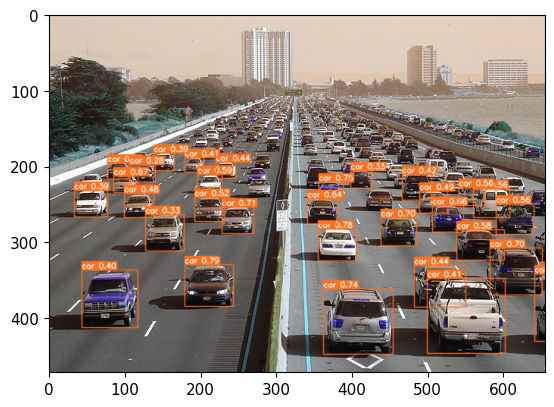

In [228]:
plt.imshow(image_drawn)
plt.show()

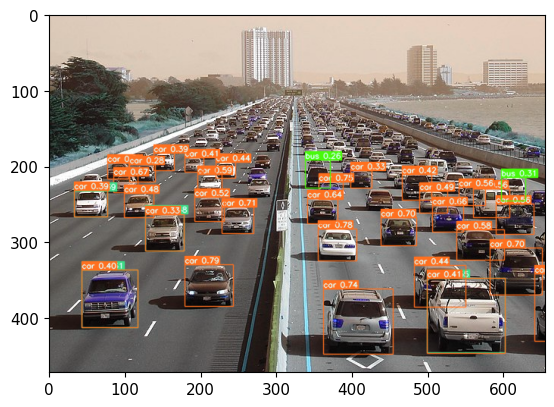

In [143]:
plt.imshow(img_1)
plt.show()

In [144]:
r = np.expand_dims(results[1], axis=0)
boxes = postprocess(r, input_hw=(480,640), orig_img=img_2)

image_drawn = draw_results(boxes[0], img_2, label_map)

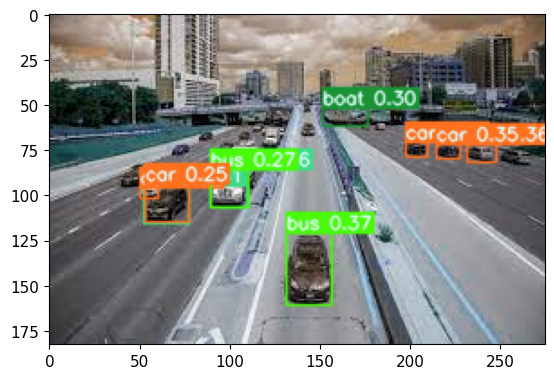

In [145]:
plt.imshow(img_2)
plt.show()

In [203]:
images_with_boxes = []
for result in results:
    result = np.expand_dims(result, axis=0)
    box = postprocess(result, input_hw=(480,640), orig_img=img)
    images_with_boxes.append(draw_results(box[0], img, label_map))

In [162]:
from trt_infer.infer import TensorRTInfer
trt_infer = TensorRTInfer('yolov8n.trt')

In [150]:
def trt_timer(f,*args):   
    start = perf_counter()
    f.infer(*args)
    return (1000 * (perf_counter() - start))

In [161]:
batch = np.array([t_img1, t_img1, t_img1, t_img1])
print(batch.shape)

(4, 3, 480, 640)


In [23]:
print(f"Yolov8 TRT: {np.mean([trt_timer(trt_infer,batch) for _ in range(10000)])} ms")

Yolov8 TRT: 8.16570611668958 ms


#### VideoProcessor -> check demo_4_videos.py